# Image Classification with Transfer Learning

## Importing Libraries

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import os
import requests
from pathlib import Path

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu126
Torchvision Version: 0.23.0+cu126
CUDA Available: False
Using device: cpu


## Loading Dataset

In [2]:
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:

    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"[INFO] Dataset already exists at {image_path}")
        return image_path

    image_path.mkdir(parents=True, exist_ok=True)

    target_file = Path(source).name

    with open(data_path / target_file, "wb") as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}")
        f.write(request.content)

    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
        print(f"[INFO] Extracting {target_file}")
        zip_ref.extractall(image_path)

    if remove_source:
        os.remove(data_path / target_file)

    return image_path

import zipfile

FOOD_VISION_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

data_dir = download_data(source=FOOD_VISION_URL,
                        destination="pizza_steak_sushi")

print(f"[SUCCESS] Dataset prepared at: {data_dir}")

[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
[INFO] Extracting pizza_steak_sushi.zip
[SUCCESS] Dataset prepared at: data/pizza_steak_sushi


## Exploring Dataset

In [3]:
def compute_dataset_statistics(data_path: Path) -> dict:
    statistics = {
        'total_samples': 0,
        'class_statistics': {},
        'split_statistics': {}
    }

    splits = ['train', 'test']
    class_names = []

    print("=== DATASET STATISTICS ANALYSIS ===\n")

    for split in splits:
        split_path = data_path / split
        if not split_path.exists():
            print(f"[WARNING] Split directory {split} not found")
            continue

        split_total = 0
        split_stats = {}

        class_dirs = [d for d in split_path.iterdir() if d.is_dir()]

        for class_dir in class_dirs:
            class_name = class_dir.name
            if class_name not in class_names:
                class_names.append(class_name)

            image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
            class_count = len(image_files)

            split_stats[class_name] = class_count
            split_total += class_count

            if class_name not in statistics['class_statistics']:
                statistics['class_statistics'][class_name] = {'train': 0, 'test': 0}

            statistics['class_statistics'][class_name][split] = class_count

        statistics['split_statistics'][split] = {
            'total': split_total,
            'classes': split_stats
        }
        statistics['total_samples'] += split_total

        print(f"{split.upper()} SET:")
        for class_name, count in split_stats.items():
            print(f"  {class_name}: {count} samples")
        print(f"  Total: {split_total} samples\n")

    print("CLASS BALANCE ANALYSIS:")
    for class_name in class_names:
        train_count = statistics['class_statistics'][class_name]['train']
        test_count = statistics['class_statistics'][class_name]['test']
        total_count = train_count + test_count
        train_ratio = train_count / total_count if total_count > 0 else 0

        print(f"{class_name}:")
        print(f"  Total: {total_count} samples")
        print(f"  Train/Test ratio: {train_ratio:.3f}/{1-train_ratio:.3f}")

    print(f"\nOVERALL DATASET:")
    print(f"Total samples: {statistics['total_samples']}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")

    return statistics

dataset_stats = compute_dataset_statistics(data_dir)

=== DATASET STATISTICS ANALYSIS ===

TRAIN SET:
  steak: 75 samples
  pizza: 78 samples
  sushi: 72 samples
  Total: 225 samples

TEST SET:
  steak: 19 samples
  pizza: 25 samples
  sushi: 31 samples
  Total: 75 samples

CLASS BALANCE ANALYSIS:
steak:
  Total: 94 samples
  Train/Test ratio: 0.798/0.202
pizza:
  Total: 103 samples
  Train/Test ratio: 0.757/0.243
sushi:
  Total: 103 samples
  Train/Test ratio: 0.699/0.301

OVERALL DATASET:
Total samples: 300
Number of classes: 3
Classes: ['steak', 'pizza', 'sushi']


## Data Visualization and Data Loading

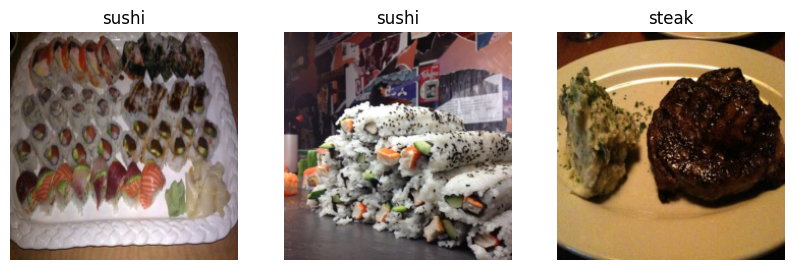

In [4]:
import random
from PIL import Image
import torch

class_names = sorted([p.name for p in (data_dir / "train").iterdir() if p.is_dir()])

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


def visualize_sample_images_from_folder(data_path: Path, class_names: list, transform: transforms.Compose, mean: list, std: list, num_images_to_plot: int = 3):
    plt.figure(figsize=(10, 10))

    image_paths = []
    for class_name in class_names:
        class_path = data_path / "train" / class_name
        image_paths.extend(list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')))

    random_image_paths = random.sample(image_paths, num_images_to_plot)

    for i, image_path in enumerate(random_image_paths):
        image = Image.open(image_path).convert("RGB")
        transformed_image = transform(image)

        class_name = image_path.parent.name
        label = class_names.index(class_name)

        unnormalized_image = transformed_image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        unnormalized_image = unnormalized_image.permute(1, 2, 0)  # Change from CxHxW to HxWx

        plt.subplot(1, num_images_to_plot, i + 1)
        plt.imshow(unnormalized_image)
        plt.title(class_names[label])
        plt.axis(False)

    plt.show()

visualize_sample_images_from_folder(data_dir, class_names, test_transform, IMAGENET_MEAN, IMAGENET_STD, num_images_to_plot=3)

In [5]:
from torchvision import transforms

def create_transform_pipelines():
    IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB channel means
    IMAGENET_STD = [0.229, 0.224, 0.225]   # RGB channel standard deviations

    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),                    # Resize to standard input size
        transforms.RandomHorizontalFlip(p=0.5),          # Random horizontal flip (50% probability)
        transforms.RandomRotation(degrees=10),           # Random rotation (±10 degrees)
        transforms.ColorJitter(brightness=0.2,           # Color augmentation
                              contrast=0.2,
                              saturation=0.2,
                              hue=0.1),
        transforms.ToTensor(),                            # Convert PIL image to tensor [0,1]
        transforms.Normalize(mean=IMAGENET_MEAN,          # Normalize using ImageNet statistics
                           std=IMAGENET_STD)
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),                    # Resize to standard input size
        transforms.ToTensor(),                            # Convert PIL image to tensor [0,1]
        transforms.Normalize(mean=IMAGENET_MEAN,          # Normalize using ImageNet statistics
                           std=IMAGENET_STD)
    ])

    return train_transforms, test_transforms
train_transform, test_transform = create_transform_pipelines()

print("=== DATA PREPROCESSING PIPELINE CONFIGURATION ===")
print(f"Training transforms: {len(train_transform.transforms)} operations")
print(f"Testing transforms: {len(test_transform.transforms)} operations")
print("\nTraining pipeline:")
for i, transform in enumerate(train_transform.transforms, 1):
    print(f"  {i}. {transform}")
print("\nTesting pipeline:")
for i, transform in enumerate(test_transform.transforms, 1):
    print(f"  {i}. {transform}")

=== DATA PREPROCESSING PIPELINE CONFIGURATION ===
Training transforms: 6 operations
Testing transforms: 3 operations

Training pipeline:
  1. Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  2. RandomHorizontalFlip(p=0.5)
  3. RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
  4. ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
  5. ToTensor()
  6. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Testing pipeline:
  1. Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  2. ToTensor()
  3. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader

def create_datasets_and_dataloaders(data_dir: Path,
                                  train_transform: transforms.Compose,
                                  test_transform: transforms.Compose,
                                  batch_size: int = 32,
                                  num_workers: int = 0,
                                  shuffle_train: bool = True) -> tuple:

    train_dataset = datasets.ImageFolder(root=data_dir / "train",
                                        transform=train_transform)

    test_dataset = datasets.ImageFolder(root=data_dir / "test",
                                       transform=test_transform)

    class_names = train_dataset.classes

    train_dataloader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=shuffle_train,
                                 num_workers=num_workers,
                                 pin_memory=True if device == "cuda" else False)

    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False,  # No shuffling for consistent evaluation
                                num_workers=num_workers,
                                pin_memory=True if device == "cuda" else False)

    return train_dataset, test_dataset, train_dataloader, test_dataloader, class_names

train_dataset, test_dataset, train_dataloader, test_dataloader, class_names = create_datasets_and_dataloaders(
    data_dir=data_dir,
    train_transform=train_transform,
    test_transform=test_transform,
    batch_size=32,
    num_workers=2
)

print("=== DATASET AND DATALOADER SUMMARY ===")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")
print(f"Batch size: {train_dataloader.batch_size}")
print(f"Training batches per epoch: {len(train_dataloader)}")
print(f"Testing batches: {len(test_dataloader)}")

=== DATASET AND DATALOADER SUMMARY ===
Training samples: 225
Testing samples: 75
Number of classes: 3
Class names: ['pizza', 'steak', 'sushi']
Batch size: 32
Training batches per epoch: 8
Testing batches: 3


## Pretrained Model

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 92.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
from torchsummary import summary

summary(model=model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [12]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [13]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Training the Model

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0795 | train_acc: 0.4336 | test_loss: 0.9550 | test_acc: 0.4564
Epoch: 2 | train_loss: 0.9541 | train_acc: 0.5820 | test_loss: 0.8542 | test_acc: 0.6723
Epoch: 3 | train_loss: 0.8544 | train_acc: 0.6797 | test_loss: 0.7075 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7961 | train_acc: 0.7188 | test_loss: 0.6867 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6513 | train_acc: 0.7656 | test_loss: 0.6095 | test_acc: 0.9072
[INFO] Total training time: 161.715 seconds


## Plot the Loss Curves

In [17]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

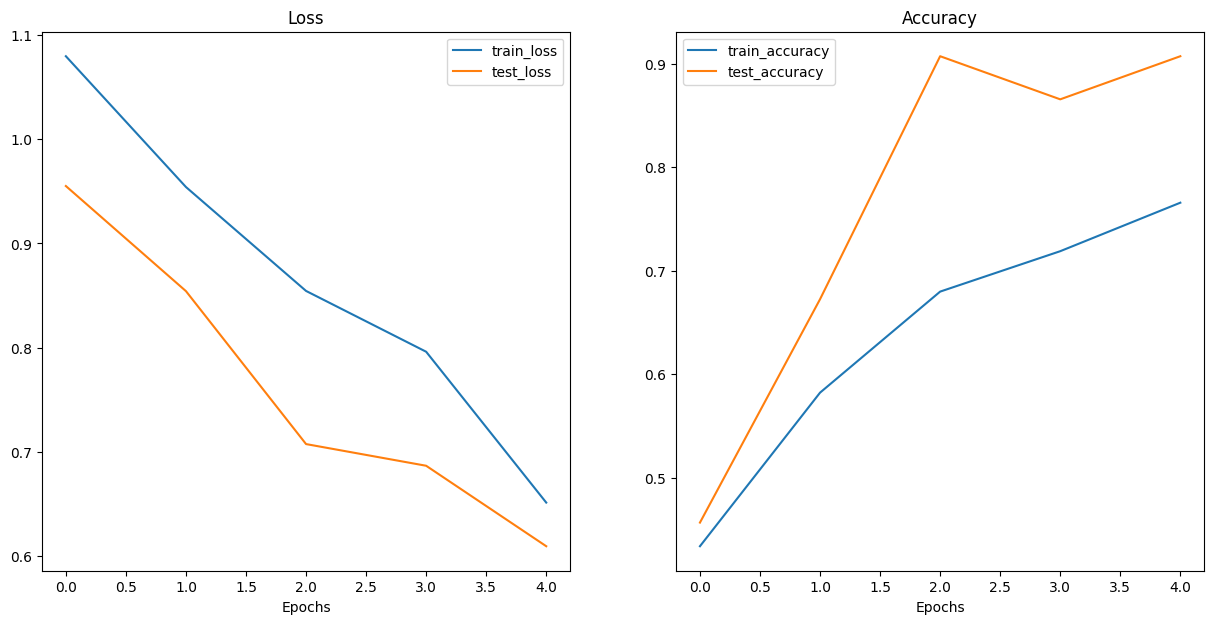

In [18]:
plot_loss_curves(results)

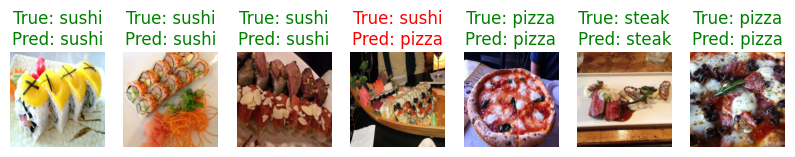

In [20]:
import random

def predict_and_plot_images(model: torch.nn.Module,
                            dataset: torch.utils.data.Dataset,
                            class_names: list,
                            num_images_to_plot: int = 3,
                            device: torch.device = device):
    model.eval()
    plt.figure(figsize=(10, 10))
    random_indices = random.sample(range(len(dataset)), k=num_images_to_plot)

    with torch.inference_mode():
        for i, idx in enumerate(random_indices):
            image, true_label = dataset[idx]
            image_on_device = image.unsqueeze(0).to(device) # Add batch dimension and send to device

            pred_logits = model(image_on_device)
            pred_prob = torch.softmax(pred_logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1).item()

            unnormalized_image = image * torch.tensor(IMAGENET_STD).view(3, 1, 1) + torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
            unnormalized_image = unnormalized_image.permute(1, 2, 0)  # Change from CxHxW to HxWx

            plt.subplot(1, num_images_to_plot, i + 1)
            plt.imshow(unnormalized_image)
            plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color="green" if pred_label == true_label else "red")
            plt.axis(False)

    plt.show()

predict_and_plot_images(model=model,
                        dataset=test_dataset,
                        class_names=class_names,
                        num_images_to_plot=7,
                        device=device)

# Image Segmentation with UNet

## Basic Things

In [30]:
!pip install kagglehub gdown > /dev/null

In [31]:
import kagglehub

In [32]:
path = kagglehub.dataset_download("fakhrealam9537/leaf-disease-segmentation-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'leaf-disease-segmentation-dataset' dataset.
Path to dataset files: /kaggle/input/leaf-disease-segmentation-dataset


In [33]:
class ROOTDIR:
    train = f"{path}/data/data/images"
    train_mask = f"{path}/data/data/masks"

In [39]:
print(train)

<function train at 0x7a6b213afec0>


## Import Libraries

In [34]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Data Exploration and Pre-processing

In [35]:
from PIL import Image

train_img_lst = sorted(os.listdir(ROOTDIR.train)) # "./train"
train_mask_lst = sorted(os.listdir(ROOTDIR.train_mask)) # "./train_masks"
sorted_train_mask_lst = sorted(train_mask_lst)
sorted_train_img_lst = sorted(train_img_lst)

In [36]:
print("Dataset Length")
print("Images:", len(train_mask_lst))
print("Masks:", len(train_img_lst))

Dataset Length
Images: 588
Masks: 588


In [37]:
print("Examining dimensions and data types:")
img_path = os.path.join(ROOTDIR.train, sorted_train_img_lst[0])
mask_path = os.path.join(ROOTDIR.train_mask, sorted_train_mask_lst[0])

img = Image.open(img_path)
mask = Image.open(mask_path)

print(f"Image Dimension = {img.size}, Data Type (PIL) = {img.format}")
print(f"Mask Dimension = {mask.size}, Data Type (PIL) = {mask.format}")

img_np = np.array(img)
mask_np = np.array(mask)
print(f"Image (numpy): Data Type = {img_np.dtype}")
print(f"Mask (numpy): Data Type = {mask_np.dtype}")

Examining dimensions and data types:
Image Dimension = (326, 235), Data Type (PIL) = JPEG
Mask Dimension = (326, 235), Data Type (PIL) = PNG
Image (numpy): Data Type = uint8
Mask (numpy): Data Type = uint8


## Data Visualization and Verfication

In [38]:
from re import I
def show_image_mask_pair(img_path, mask_path):
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

for i in range(3):
  if 'val_images_list' in locals() and 'val_masks_list' in locals() and len(sorted_train_img_lst) > 0:
      example_img_path = os.path.join(ROOTDIR.train, sorted_train_img_lst[i])
      example_mask_path = os.path.join(ROOTDIR.train_mask, sorted_train_mask_lst[i])
      print("Image: ", i+1)
      show_image_mask_pair(example_img_path, example_mask_path)
  else:
      print("Validation lists not defined or empty. Cannot display example.")

Validation lists not defined or empty. Cannot display example.
Validation lists not defined or empty. Cannot display example.
Validation lists not defined or empty. Cannot display example.
